In [763]:
import wfdb
import mne
import numpy as np

record_path = "Desktop/PSG data/slp01a"

record = wfdb.rdrecord(record_path)
annotation = wfdb.rdann(record_path, 'st')

annotation_mne = mne.Annotations(
    onset=annotation.sample / record.fs,
    duration=30,
    description=annotation.aux_note
)

signals = record.p_signal  # Signal data as NumPy array
sampling_rate = record.fs  # Sampling frequency (e.g., 250 Hz)
channel_names = record.sig_name  # Channel names

# Define channel types (all 'misc' by default; adjust based on signal type)
channel_types = ["eeg" if "EEG" in ch else "misc" for ch in channel_names]

# Create MNE Info object
info = mne.create_info(
    ch_names=channel_names,
    sfreq=sampling_rate,
    ch_types=channel_types
)

# Convert signals to MNE RawArray
raw = mne.io.RawArray(signals.T, info)

# Add annotations to the raw object
raw.set_annotations(annotation_mne)

Creating RawArray with float64 data, n_channels=4, n_times=1800000
    Range : 0 ... 1799999 =      0.000 ...  7199.996 secs
Ready.


<RawArray | 4 x 1800000 (7200.0 s), ~54.9 MiB, data loaded>

C:\Users\piotr\AppData\Local\Temp\ipykernel_17452\2473977420.py:1: RuntimeWarning: The unit for channel(s) ECG, Resp (sum) has changed from NA to V.
  raw.set_channel_types({"ECG":"ecg","Resp (sum)": "resp","BP":"misc"})


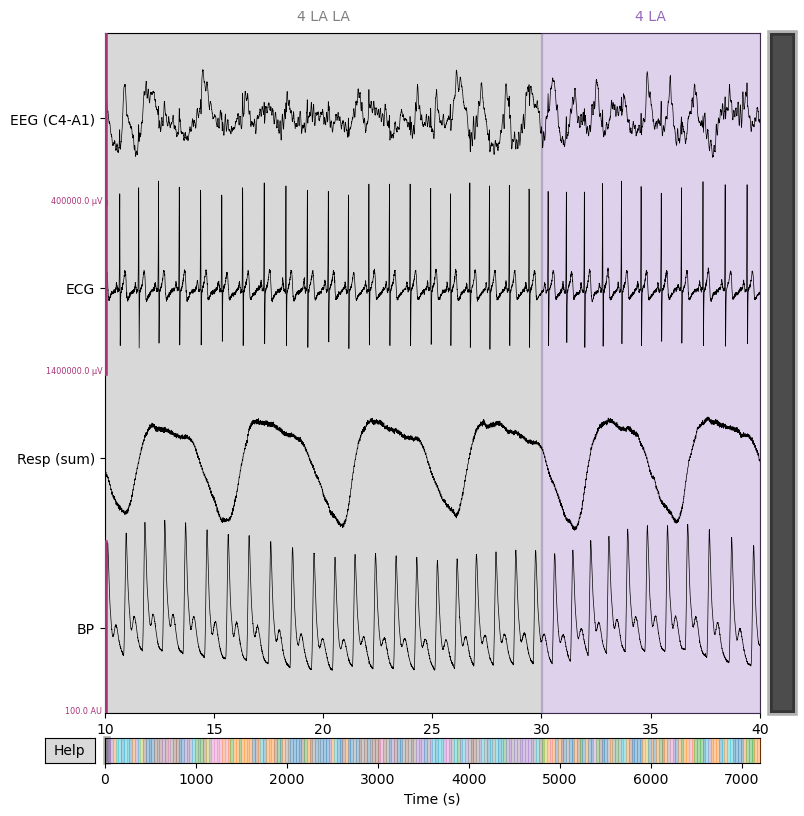

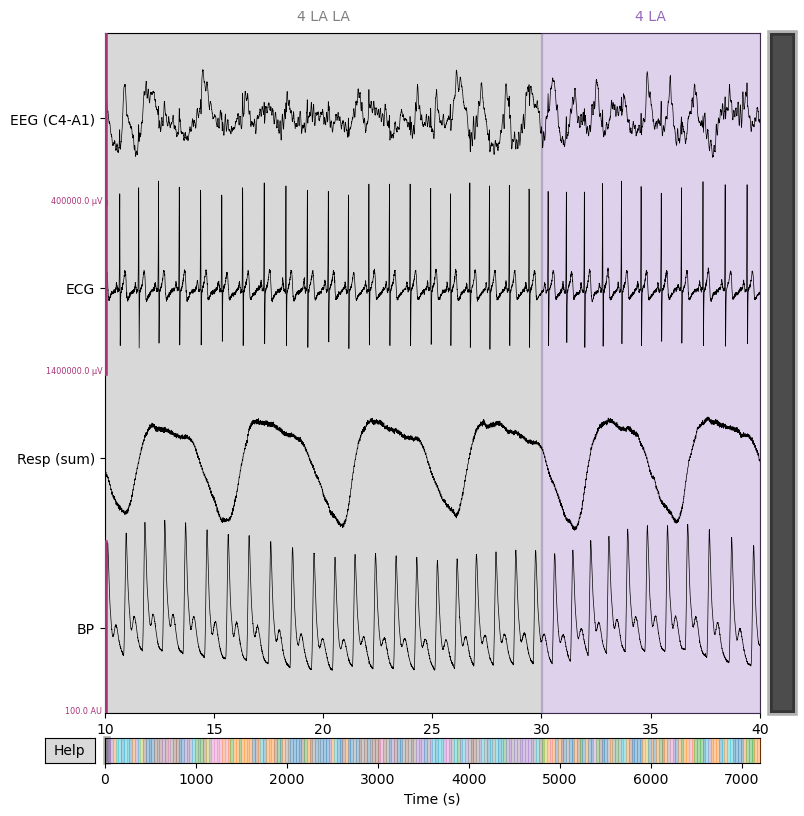

In [765]:
raw.set_channel_types({"ECG":"ecg","Resp (sum)": "resp","BP":"misc"})
# Plot raw data with dynamic scaling and exclude BP
raw.plot(start=10,duration=30,color="k",
    picks=["ECG","BP",'Resp (sum)',"EEG (C4-A1)"],
    scalings=dict(eeg=0.2,  ecg=0.7, resp=1,misc=50),
    title="PSG Data Excluding BP")

In [799]:
x,y=mne.events_from_annotations(raw)
print(x,y)

Used Annotations descriptions: ['1 LA', '2', '2 H', '2 H H', '2 H LA', '2 HA', '2 L', '2 L HA', '2 L LA', '2 LA', '2 LA H', '2 LA HA', '2 LA L', '2 LA LA', '3', '3 H', '3 H LA', '3 HA', '3 L', '3 L HA LA', '3 L L', '3 L LA', '3 LA', '3 LA L', '3 LA LA', '4', '4 L', '4 L L', '4 L L L', '4 L LA', '4 LA', '4 LA HA LA', '4 LA L', '4 LA LA', 'MT', 'R', 'R H', 'R HA', 'W', 'W HA', 'W LA']
[[      1       0      34]
 [   7500       0      31]
 [  15000       0      31]
 [  22500       0      29]
 [  30000       0      27]
 [  37500       0      27]
 [  45000       0      28]
 [  52500       0      27]
 [  60000       0      27]
 [  67500       0      28]
 [  75000       0      29]
 [  82500       0      31]
 [  90000       0      18]
 [  97500       0      17]
 [ 105000       0      23]
 [ 112500       0      10]
 [ 120000       0      10]
 [ 127500       0      10]
 [ 135000       0      23]
 [ 142500       0      25]
 [ 150000       0      23]
 [ 157500       0      22]
 [ 165000       0   

In [803]:
#redefine event
from collections import defaultdict
new_id = {}
for desc in raw.annotations.description:
    if "H" in desc or "HA" in desc:  # Hypopnea
        new_id[desc] = 1
    elif " A " in desc or "X" in desc:  # Obstructive Apnea
        new_id[desc] = 2
    elif "CA" in desc or "CAA" in desc:  # Central Apnea
        new_id[desc] = 3
    else:  # Other
        new_id[desc] = 4

# Generate events with the new mapping
events, event_id = mne.events_from_annotations(raw, event_id=new_id)

Used Annotations descriptions: ['1 LA', '2', '2 H', '2 H H', '2 H LA', '2 HA', '2 L', '2 L HA', '2 L LA', '2 LA', '2 LA H', '2 LA HA', '2 LA L', '2 LA LA', '3', '3 H', '3 H LA', '3 HA', '3 L', '3 L HA LA', '3 L L', '3 L LA', '3 LA', '3 LA L', '3 LA LA', '4', '4 L', '4 L L', '4 L L L', '4 L LA', '4 LA', '4 LA HA LA', '4 LA L', '4 LA LA', 'MT', 'R', 'R H', 'R HA', 'W', 'W HA', 'W LA']


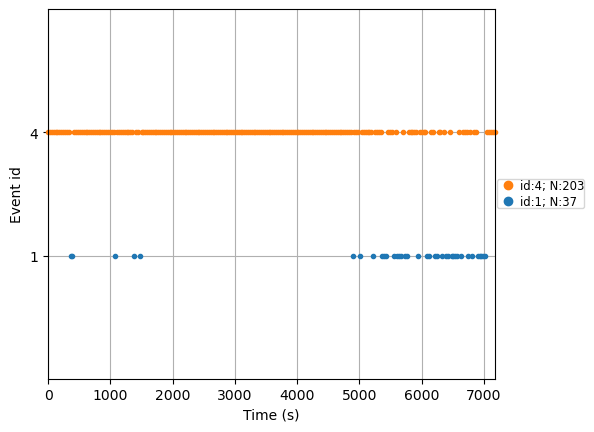

In [807]:
import matplotlib.pyplot as plt
# Plot the events
fig = mne.viz.plot_events(
    events,
    sfreq=raw.info["sfreq"],  # Sampling frequency of the raw data
    first_samp=raw.first_samp,  # First sample index of the raw data
)

# Extract color cycle for event colors
stage_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

plt.show()